# Preamble

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision

import matplotlib.pyplot as plt
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from google.colab import drive

from google.colab import files
import os
import copy
import pickle

import random

import torch.nn as nn
import torch.nn.functional as F
from random import shuffle
import torch.optim as optim

plt.rcParams["mathtext.default"]= 'regular'
plt_fontsize_text_ = 9
plt_fontsize_title_ = 9
plt_fontsize_label_ = 6
plt_fontsize_legend_ = 5


color_cycle =  [u'#1f77b4'    , u'#ff7f0e'    , u'#2ca02c'   , u'#d62728'   , u'#7f7f7f'   , u'#17becf'     , u'#9467bd'    ,  u'#8c564b'    , u'#e377c2'  ,   u'#7f7f7f' ]
color_cycle2 = [u'#1f77b455'  , u'#ff7f0e55'  , u'#2ca02c55' , u'#d6272855' , u'#7f7f7f55' , u'#17becf55'   , u'#9467bd55'  ,  u'#8c564b55'  , u'#e377c255'  ,   u'#7f7f7f55' ]

cm_to_inch = 1/2.54  # centimeters in inches
figure_width1 = 9*cm_to_inch
figure_width2 = 19*cm_to_inch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


mount_drive = False
# base_directory_str = '/content/gdrive/My Drive/bio_NN_research/neural_balance'
base_directory_str = None

if mount_drive and (base_directory_str!= None):
    drive.mount('/content/gdrive', force_remount=True)




    base_directory_data_str =  base_directory_str + '/data/neural_balance_v1/FC_MNIST/'
    base_directory_figure_str =  base_directory_str + '/figures/neural_balance_v1/FC_MNIST/'



    if not os.path.exists(  base_directory_data_str  ):
        os.makedirs( base_directory_data_str )
        print("data saving path did not exist and created")


    if not os.path.exists(  base_directory_figure_str  ):
        os.makedirs( base_directory_figure_str )
        print("figure saving path did not exist and created")


import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)



def export_legend(legend, filename  , expand=[-3,-3,3,3]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)





cpu


# Preparing the dataset

In [ ]:

def get_MNIST_dataset( coding_layers , ones_in_layes    , batch_size , device = device  , flatten = True ,  size = 28 , code_map = None , shuffle  = False , initial_shuffle = False  ):

  MNIST_original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True , download=True  ,   transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize( size  ), torchvision.transforms.ToTensor()]

        ))

  MNIST_original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False , download=True   ,  transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize( size  ), torchvision.transforms.ToTensor()]

        ))

  num_workers = 0




  train_targets = MNIST_original_train_dataset.targets

  x_train = MNIST_original_train_dataset.data




  if initial_shuffle == True:
    arr = list(range(x_train.shape[0]))
    np.random.shuffle(arr)


    x_train[list(range(x_train.shape[0]))] = x_train[arr]
    train_targets[list(range(x_train.shape[0]))] = train_targets[arr]




  x_train = x_train / 255.0

  if size!=28:
    dataset_data_resized = torch.zeros([ len(MNIST_original_train_dataset) , size , size ]).to(dtype)

    for i in range( len(MNIST_original_train_dataset)   ):
      dataset_data_resized[i] = torch.tensor(  cv2.resize( x_train[i].numpy()  ,  ( int( size ) , int( size )  )  ) ).to(dtype)

    x_train = dataset_data_resized

  if (flatten == True ):
    x_train = x_train.reshape(  [ x_train.shape[0] , -1 ]  ) .to(dtype)
  else:
    x_train = x_train.unsqueeze(  1)


  x_test = MNIST_original_test_dataset.data / 255.0

  if size!=28:
    dataset_data_resized = torch.zeros([ len(MNIST_original_test_dataset) , size , size ]).to(dtype)

    for i in range( len(MNIST_original_test_dataset)   ):
      dataset_data_resized[i] = torch.tensor(  cv2.resize( x_test[i].numpy()  ,  ( int( size ) , int( size )  )  ) ).to(dtype)

    x_test = dataset_data_resized

  if (flatten == True ):
    x_test = x_test.reshape(  [ MNIST_original_test_dataset.data.shape[0] , -1 ]  ) .to(dtype)
  else:
     x_test = x_test.unsqueeze(  1)






  train_dataset = torch.utils.data.TensorDataset(   x_train.to('cpu')    ,  MNIST_original_train_dataset.targets.to(dtype).to('cpu')      )
  test_dataset  = torch.utils.data.TensorDataset(   x_test.to('cpu')     ,  MNIST_original_test_dataset.targets.to(dtype).to('cpu')         )

  train_loader = torch.utils.data.DataLoader( dataset=train_dataset , batch_size=batch_size , shuffle=shuffle , num_workers=num_workers , pin_memory=True )
  test_loader = torch.utils.data.DataLoader(  dataset=test_dataset , batch_size=batch_size , shuffle=False , num_workers=num_workers ,pin_memory=True    )

  inputs, classes = next(iter(train_loader))


  inputs, classes = next(iter(test_loader))



  x_shape = inputs.shape[1:]
  return train_loader , test_loader , x_shape


batch_size = 200

width_height_input_image = 28 # height and width of images
train_loader , test_loader , x_shape  =  get_MNIST_dataset(  coding_layers = [50]  , ones_in_layes = [ 5 ]
                                                                                    , batch_size=batch_size , device = device
                                                                                    , flatten = True
                                                                                     , size= width_height_input_image
                                                           , shuffle  = True , initial_shuffle = True )




input_image_size = width_height_input_image*width_height_input_image


test_dataset = test_loader.dataset


test_tensor = test_dataset.tensors[0].to(device)
targets_tensor = test_dataset.tensors[1].to(device)

ten_samples = torch.zeros([10,test_tensor.shape[1]])


# seperate 10 digits for illustrtion
j=0
for  i in range(targets_tensor.shape[0]):
    if targets_tensor[i] == j:

        ten_samples[j,: ] = test_tensor[i,:]
        j = j + 1
        if j== 10:
            break



X = test_tensor[0:200,:]

# print(len(train_loader))
# print(targets_tensor.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 71605223.42it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32519649.35it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 11112614.84it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5230787.69it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



# Plot function

the functions that we have defined in this section are later used to plot data

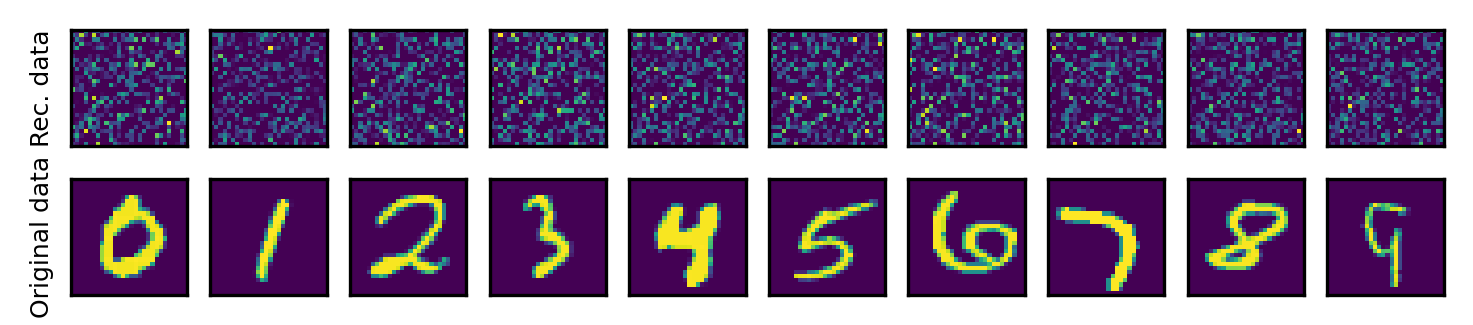

In [ ]:
def plot_input_samples_after_applied_to_net(W_list,B_list,samples,original_size,activation_function ,bias = None):



    linewidth_1 = 1
    linestyle_1 = '-'



    n_col = samples.shape[0]
    n_row = 2

    figsize_ = (figure_width1/2/3*n_col , figure_width1/3 )
    plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w')

    # Z = samples
    # L = activation_function(Z)
    L=samples

    for l in range(len(W_list)):
        Z = L@W_list[l]
        if bias!=None:
            Z=Z+bias[l]
        L = activation_function(Z)

    for l in reversed( range(len(B_list) ) ):

        Z = L@B_list[l]
        if bias!=None:
            Z=Z+bias[l]
        L = activation_function(Z)


    for i in range(samples.shape[0]):


        plt.subplot(n_row,n_col,i+1)
        plt.imshow(L[i,:].view(original_size))
        ax = plt.gca()
        # plt.axis('off')
        if i==0:
            plt.ylabel("Rec. data"  , fontsize= plt_fontsize_label_)
        # plt.gca().axes.get_yaxis().set_visible(False)
        # plt.gca().axes.get_xaxis().set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])


        plt.subplot(n_row,n_col,i+1+n_col)
        plt.imshow(samples[i,:].view(original_size))
        ax = plt.gca()
        # plt.axis('off')

        if i==0:
            plt.ylabel("Original data"  , fontsize= plt_fontsize_label_)
        # plt.gca().axes.get_yaxis().set_visible(False)
        # plt.gca().axes.get_xaxis().set_visible(False)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


def activation_function(x):
    # return torch.tanh(torch.relu(x))
    # return torch.sigmoid(x)
    return torch.relu(x)




    # return x



plot_input_samples_after_applied_to_net( [torch.randn([input_image_size , 100])]
                                        , [torch.randn([100 , input_image_size])]
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)



# balance_neurons_in_the_middle_of_fc_layers

In [ ]:
def balance_neurons_in_the_middle_of_fc_layers( fc1 , fc2  , ratio     , n   ):

  with torch.no_grad() :


    nn=0
    for i in random.sample(range(ratio.shape[0]) , (ratio.shape[0]) ):



          fc1.weight.data [i,:] *= ratio[  i ].item()

          fc2.weight.data [:,i] /= ratio[  i ].item()





          nn +=1
          if nn > n:
            break





# network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F




class Net(nn.Module):
    def __init__(self):
        super().__init__()



        self.fc1 = nn.Linear(28*28  , 200 , bias=False)
        self.fc2 = nn.Linear(200, 100 , bias=False)
        self.fc3 = nn.Linear(100, 50 , bias=False)
        self.fc4 = nn.Linear(50, 100 , bias=False)
        self.fc5 = nn.Linear(100, 200 , bias=False)
        self.fc6 = nn.Linear(200, 28*28 , bias=False)





        initial_std = 0.1

        self.fc1.weight.data.copy_(torch.randn_like( self.fc1.weight.data) *initial_std )
        self.fc2.weight.data.copy_(torch.randn_like( self.fc2.weight.data)  *initial_std)
        self.fc3.weight.data.copy_(torch.randn_like( self.fc3.weight.data)  *initial_std )
        self.fc4.weight.data.copy_(torch.randn_like( self.fc4.weight.data)  *initial_std )
        self.fc5.weight.data.copy_(torch.randn_like( self.fc5.weight.data)  *initial_std )
        self.fc6.weight.data.copy_(torch.randn_like( self.fc6.weight.data)  *initial_std )





    def forward(self, x):
        self.x0 = x
        self.x1 = F.relu(self.fc1(self.x0))
        self.x2 = F.relu(self.fc2(self.x1))
        self.x3 = F.relu(self.fc3(self.x2))
        self.x4 = F.relu(self.fc4(self.x3))
        self.x5 = F.relu(self.fc5(self.x4))
        self.x6 = F.relu(self.fc6(self.x5))


        return self.x6


    def save_weights(self ):

        self.save_weights_fc1 = self.fc1.weight.data.clone()
        self.save_weights_fc2 = self.fc2.weight.data.clone()
        self.save_weights_fc3 = self.fc3.weight.data.clone()
        self.save_weights_fc4 = self.fc4.weight.data.clone()
        self.save_weights_fc5 = self.fc5.weight.data.clone()
        self.save_weights_fc6 = self.fc6.weight.data.clone()



    def load_weights(self ):

        self.fc1.weight.data.copy_(self.save_weights_fc1 )
        self.fc2.weight.data.copy_(self.save_weights_fc2 )
        self.fc3.weight.data.copy_(self.save_weights_fc3 )
        self.fc4.weight.data.copy_(self.save_weights_fc4 )
        self.fc5.weight.data.copy_(self.save_weights_fc5 )
        self.fc6.weight.data.copy_(self.save_weights_fc6 )



    def reinitialize_weights(self , initial_std = 0.1):


        self.fc1.weight.data.copy_(torch.randn_like( self.fc1.weight.data) *initial_std )
        self.fc2.weight.data.copy_(torch.randn_like( self.fc2.weight.data)  *initial_std)
        self.fc3.weight.data.copy_(torch.randn_like( self.fc3.weight.data)  *initial_std )
        self.fc4.weight.data.copy_(torch.randn_like( self.fc4.weight.data)  *initial_std )
        self.fc5.weight.data.copy_(torch.randn_like( self.fc5.weight.data)  *initial_std )
        self.fc6.weight.data.copy_(torch.randn_like( self.fc6.weight.data)  *initial_std )

    def get_norm_of_neural_activity(self):
        with torch.no_grad() :
            return torch.sqrt( self.x1.norm()**2 + self.x2.norm()**2 + self.x3.norm()**2 + self.x4.norm()**2 + self.x5.norm()**2 + self.x6.norm()**2 )



    def neuron_wise_imbalancement(self):
        # print("neuron_wise_imbalancement start")
        with torch.no_grad() :

            sum = 0




            norm_in = (self.fc1.weight.data**2).sum(dim=1)

            norm_out =  (self.fc2.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()



            norm_in = (self.fc2.weight.data**2).sum(dim=1)

            norm_out =  (self.fc3.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()



            norm_in = (self.fc3.weight.data**2).sum(dim=1)

            norm_out =  (self.fc4.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()


            norm_in = (self.fc4.weight.data**2).sum(dim=1)

            norm_out =  (self.fc5.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()




            norm_in = (self.fc5.weight.data**2).sum(dim=1)

            norm_out =  (self.fc6.weight.data**2).sum(dim=0)

            sum += ((norm_in - norm_out)**2).sum()




            return sum




    def neuron_wise_imbalancement_L1(self):
        # print("neuron_wise_imbalancement start")
        with torch.no_grad() :

            sum = 0




            norm_in = (self.fc1.weight.data).abs().sum(dim=1)

            norm_out =  (self.fc2.weight.data).abs().sum(dim=0)

            sum += ((norm_in - norm_out).abs()).sum()



            norm_in = (self.fc2.weight.data).abs().sum(dim=1)

            norm_out =  (self.fc3.weight.data).abs().sum(dim=0)

            sum += ((norm_in - norm_out).abs()).sum()



            norm_in = (self.fc3.weight.data).abs().sum(dim=1)

            norm_out =  (self.fc4.weight.data).abs().sum(dim=0)

            sum += ((norm_in - norm_out).abs()).sum()


            norm_in = (self.fc4.weight.data).abs().sum(dim=1)

            norm_out =  (self.fc5.weight.data).abs().sum(dim=0)

            sum += ((norm_in - norm_out).abs()).sum()




            norm_in = (self.fc5.weight.data).abs().sum(dim=1)

            norm_out =  (self.fc6.weight.data).abs().sum(dim=0)

            sum += ((norm_in - norm_out).abs()).sum()




            return sum



    def norm_of_weights(self):
        norm = 0


        norm+=self.fc1.weight.data.norm()**2
        norm+=self.fc2.weight.data.norm()**2
        norm+=self.fc3.weight.data.norm()**2
        norm+=self.fc4.weight.data.norm()**2
        norm+=self.fc5.weight.data.norm()**2
        norm+=self.fc6.weight.data.norm()**2



        return norm



    def weight_decay(self,wd):
        with torch.no_grad() :



          self.fc1.weight.data -= self.fc1.weight.data * wd
          self.fc2.weight.data -= self.fc2.weight.data * wd
          self.fc3.weight.data -= self.fc3.weight.data * wd
          self.fc4.weight.data -= self.fc4.weight.data * wd
          self.fc5.weight.data -= self.fc5.weight.data * wd
          self.fc6.weight.data -= self.fc6.weight.data * wd

    def regularization_L1(self,wd):
        with torch.no_grad() :



          self.fc1.weight.data -= torch.sign(self.fc1.weight.data) * wd
          self.fc2.weight.data -= torch.sign(self.fc2.weight.data) * wd
          self.fc3.weight.data -= torch.sign(self.fc3.weight.data) * wd
          self.fc4.weight.data -= torch.sign(self.fc4.weight.data) * wd
          self.fc5.weight.data -= torch.sign(self.fc5.weight.data) * wd
          self.fc6.weight.data -= torch.sign(self.fc6.weight.data) * wd

    def stochastic_balance(self):
        # print("stochastic_balance start")
        with torch.no_grad() :
            iii = random.randint(0, 4)
            # iii = 3


            if iii == 0:

              norm_in = (self.fc1.weight.data**2).sum(dim=1)
              norm_out =  (self.fc2.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc1 , self.fc2  , ratio = ratio     , n = 999999999999   )


            if iii == 1:


              norm_in = (self.fc2.weight.data**2).sum(dim=1)
              norm_out =  (self.fc3.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc2 , self.fc3  , ratio = ratio     , n = 999999999999   )





            if iii == 2:

              norm_in = (self.fc3.weight.data**2).sum(dim=1)
              norm_out =  (self.fc4.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc3 , self.fc4  , ratio = ratio     , n = 999999999999   )


            if iii == 3:

              norm_in = (self.fc4.weight.data**2).sum(dim=1)
              norm_out =  (self.fc5.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc4 , self.fc5  , ratio = ratio     , n = 999999999999   )

            if iii == 4:

              norm_in = (self.fc5.weight.data**2).sum(dim=1)
              norm_out =  (self.fc6.weight.data**2).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()


              balance_neurons_in_the_middle_of_fc_layers( self.fc5 , self.fc6 , ratio = ratio     , n = 99999999999   )


    def stochastic_unbalance(self):
        # print("stochastic_balance start")
        with torch.no_grad() :
            iii = random.randint(0, 4)
            # iii = 3


            if iii == 0:

              norm_in = (self.fc1.weight.data**2).sum(dim=1)
              norm_out =  (self.fc2.weight.data**2).sum(dim=0)
              ratio = (norm_in / norm_out ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc1 , self.fc2  , ratio = ratio     , n = 999999999999   )


            if iii == 1:


              norm_in = (self.fc2.weight.data**2).sum(dim=1)
              norm_out =  (self.fc3.weight.data**2).sum(dim=0)
              ratio = (norm_in / norm_out ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc2 , self.fc3  , ratio = ratio     , n = 999999999999   )





            if iii == 2:

              norm_in = (self.fc3.weight.data**2).sum(dim=1)
              norm_out =  (self.fc4.weight.data**2).sum(dim=0)
              ratio = (norm_in / norm_out ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc3 , self.fc4  , ratio = ratio     , n = 999999999999   )


            if iii == 3:

              norm_in = (self.fc4.weight.data**2).sum(dim=1)
              norm_out =  (self.fc5.weight.data**2).sum(dim=0)
              ratio = (norm_in / norm_out ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc4 , self.fc5  , ratio = ratio     , n = 999999999999   )

            if iii == 4:

              norm_in = (self.fc5.weight.data**2).sum(dim=1)
              norm_out =  (self.fc6.weight.data**2).sum(dim=0)
              ratio = (norm_in / norm_out ).sqrt().sqrt()


              balance_neurons_in_the_middle_of_fc_layers( self.fc5 , self.fc6 , ratio = ratio     , n = 99999999999   )


    def stochastic_unbalance2(self):
        # print("stochastic_balance start")
        with torch.no_grad() :
            iii = random.randint(0, 4)
            # iii = 3


            if iii == 0:

              norm_in = (self.fc1.weight.data**2).sum(dim=1)

              ratio = torch.rand_like(norm_in)*2+0.00001



              balance_neurons_in_the_middle_of_fc_layers( self.fc1 , self.fc2  , ratio = ratio     , n = 999999999999   )


            if iii == 1:


              norm_in = (self.fc2.weight.data**2).sum(dim=1)
              ratio = torch.rand_like(norm_in)*2+0.00001




              balance_neurons_in_the_middle_of_fc_layers( self.fc2 , self.fc3  , ratio = ratio     , n = 999999999999   )





            if iii == 2:

              norm_in = (self.fc3.weight.data**2).sum(dim=1)
              ratio = torch.rand_like(norm_in)*2+0.00001




              balance_neurons_in_the_middle_of_fc_layers( self.fc3 , self.fc4  , ratio = ratio     , n = 999999999999   )


            if iii == 3:

              norm_in = (self.fc4.weight.data**2).sum(dim=1)
              ratio = torch.rand_like(norm_in)*2+0.00001



              balance_neurons_in_the_middle_of_fc_layers( self.fc4 , self.fc5  , ratio = ratio     , n = 999999999999   )

            if iii == 4:

              norm_in = (self.fc5.weight.data**2).sum(dim=1)
              ratio = torch.rand_like(norm_in)*2+0.00001



              balance_neurons_in_the_middle_of_fc_layers( self.fc5 , self.fc6 , ratio = ratio     , n = 99999999999   )


    def stochastic_balance_L1(self):
        # print("stochastic_balance start")
        with torch.no_grad() :
            iii = random.randint(0, 4)
            # iii = 3


            if iii == 0:

              norm_in = (self.fc1.weight.data).abs().sum(dim=1)
              norm_out =  (self.fc2.weight.data).abs().sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc1 , self.fc2  , ratio = ratio     , n = 999999999999   )


            if iii == 1:


              norm_in = (self.fc2.weight.data).abs().sum(dim=1)
              norm_out =  (self.fc3.weight.data).abs().sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc2 , self.fc3  , ratio = ratio     , n = 999999999999   )





            if iii == 2:

              norm_in = (self.fc3.weight.data.abs()).sum(dim=1)
              norm_out =  (self.fc4.weight.data.abs()).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc3 , self.fc4  , ratio = ratio     , n = 999999999999   )


            if iii == 3:

              norm_in = (self.fc4.weight.data.abs()).sum(dim=1)
              norm_out =  (self.fc5.weight.data.abs()).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()



              balance_neurons_in_the_middle_of_fc_layers( self.fc4 , self.fc5  , ratio = ratio     , n = 999999999999   )

            if iii == 4:

              norm_in = (self.fc5.weight.data.abs()).sum(dim=1)
              norm_out =  (self.fc6.weight.data.abs()).sum(dim=0)
              ratio = (norm_out/norm_in ).sqrt().sqrt()


              balance_neurons_in_the_middle_of_fc_layers( self.fc5 , self.fc6 , ratio = ratio     , n = 99999999999   )






net = Net()







# 1) illustrating that gd applied to E in general does not converge to a balanced state (unless starting state is balanced and learning rate is infinitely small)

In [ ]:
net = Net()
net.to(device)





Net(
  (fc1): Linear(in_features=784, out_features=200, bias=False)
  (fc2): Linear(in_features=200, out_features=100, bias=False)
  (fc3): Linear(in_features=100, out_features=50, bias=False)
  (fc4): Linear(in_features=50, out_features=100, bias=False)
  (fc5): Linear(in_features=100, out_features=200, bias=False)
  (fc6): Linear(in_features=200, out_features=784, bias=False)
)

## small lr , unbalanced

In [ ]:


N_repeat = 10
N_epoch  = 10
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(train_loader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );



neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')


for rep_i in range(N_repeat):
    iteration = 0

    net.reinitialize_weights(.1)




    criterion = nn.MSELoss(reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=0.00002)

    print(f"\nrep_i: {rep_i}\n")
    running_loss = 0.0

    for epoch in range(N_epoch):

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)


            inputs = inputs.view(inputs.shape[0],-1)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()


            norm_W[0,rep_i,iteration] =  net.norm_of_weights()

            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()





            optimizer.step()






            running_loss += loss.item()



            if iteration % 100 == 99:
                loss_tensor[ rep_i,iteration] =  running_loss/100

                if iteration % 500 == 499:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss } neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}')


                running_loss = 0.0

            iteration +=1

print('Training Finished')

LC_BP_without_L2_regularization_small_lr = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32) ,
  "norm_W" : norm_W.clone().cpu().to(torch.float32)  ,
  "loss_tensor" : loss_tensor.clone().cpu().to(torch.float32)

}




if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_small_lr  , fp)





rep_i: 0

[2,   200] loss: 673168.2587890625 neuron_wise_imbalancement_t: 19030.5078125
[4,   100] loss: 549518.5581054688 neuron_wise_imbalancement_t: 18986.3125
[5,   300] loss: 494141.5078125 neuron_wise_imbalancement_t: 18940.501953125
[7,   200] loss: 459943.6726074219 neuron_wise_imbalancement_t: 18894.1171875
[9,   100] loss: 433344.4025878906 neuron_wise_imbalancement_t: 18848.341796875
[10,   300] loss: 408859.5927734375 neuron_wise_imbalancement_t: 18803.68359375

rep_i: 1

[2,   200] loss: 711120.5883789062 neuron_wise_imbalancement_t: 19172.51171875
[4,   100] loss: 578875.142578125 neuron_wise_imbalancement_t: 19127.7265625
[5,   300] loss: 500429.1650390625 neuron_wise_imbalancement_t: 19084.208984375
[7,   200] loss: 459848.0791015625 neuron_wise_imbalancement_t: 19041.8359375
[9,   100] loss: 437563.16015625 neuron_wise_imbalancement_t: 18999.88671875
[10,   300] loss: 411004.0625 neuron_wise_imbalancement_t: 18956.18359375

rep_i: 2

[2,   200] loss: 720099.7456054688

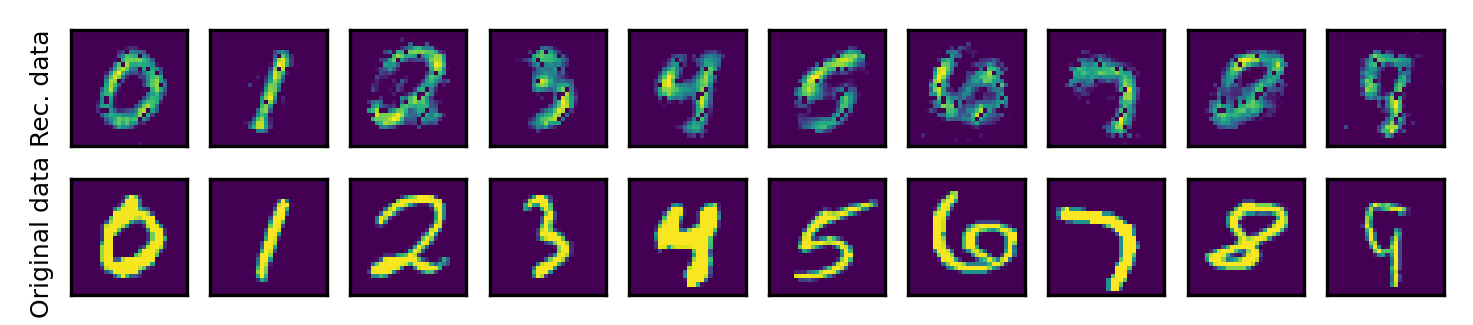

In [ ]:
plot_input_samples_after_applied_to_net( [ net.fc1.weight.data.t() , net.fc2.weight.data.t()
                                          , net.fc3.weight.data.t() , net.fc4.weight.data.t()
                                          , net.fc5.weight.data.t() , net.fc6.weight.data.t()]
                                        , []
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)


## big lr , unbalanced

In [ ]:



N_repeat = 10
N_epoch  = 10
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(train_loader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0



for rep_i in range(N_repeat):
    iteration = 0
    net.reinitialize_weights(.1)




    criterion = nn.MSELoss(reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=0.00005)


    print(f"\nrep_i: {rep_i}\n")
    running_loss = 0.0

    for epoch in range(N_epoch):

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)


            inputs = inputs.view(inputs.shape[0],-1)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            norm_W[0,rep_i,iteration] =  net.norm_of_weights()

            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()



            optimizer.step()






            running_loss += loss.item()



            if iteration % 100 == 99:
                loss_tensor[ rep_i,iteration] =  running_loss/100

                if iteration % 500 == 499:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss } neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}')


                running_loss = 0.0

            iteration +=1

print('Training Finished')

LC_BP_without_L2_regularization_big_lr = {

  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32) ,
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32) ,
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}










if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_big_lr  , fp)



rep_i: 0

[2,   200] loss: 708555.7612304688 neuron_wise_imbalancement_t: 19148.21484375
[4,   100] loss: 568804.1850585938 neuron_wise_imbalancement_t: 19100.9453125
[5,   300] loss: 500898.7138671875 neuron_wise_imbalancement_t: 19057.619140625
[7,   200] loss: 464500.07080078125 neuron_wise_imbalancement_t: 19014.5390625
[9,   100] loss: 432285.71728515625 neuron_wise_imbalancement_t: 18974.18359375
[10,   300] loss: 411038.2692871094 neuron_wise_imbalancement_t: 18932.78515625

rep_i: 1

[2,   200] loss: 678487.0600585938 neuron_wise_imbalancement_t: 19145.142578125
[4,   100] loss: 549193.0961914062 neuron_wise_imbalancement_t: 19106.439453125
[5,   300] loss: 485141.9501953125 neuron_wise_imbalancement_t: 19070.455078125
[7,   200] loss: 454430.4582519531 neuron_wise_imbalancement_t: 19034.86328125
[9,   100] loss: 429899.6008300781 neuron_wise_imbalancement_t: 18999.830078125
[10,   300] loss: 413395.7978515625 neuron_wise_imbalancement_t: 18964.39453125

rep_i: 2

[2,   200] l

In [ ]:
plot_input_samples_after_applied_to_net( [ net.fc1.weight.data.t() , net.fc2.weight.data.t()
                                          , net.fc3.weight.data.t() , net.fc4.weight.data.t()
                                          , net.fc5.weight.data.t() , net.fc6.weight.data.t()]
                                        , []
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)


## big lr , unbalanced with L2 regularizer

In [ ]:













N_repeat = 10
N_epoch  = 10
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(train_loader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );



neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0


for rep_i in range(N_repeat):
    net.reinitialize_weights(.1)
    criterion = nn.MSELoss(reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=0.000044)

    iteration = 0
    print(f"\nrep_i: {rep_i}\n")
    running_loss = 0.0

    for epoch in range(N_epoch):

        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)


            inputs = inputs.view(inputs.shape[0],-1)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            norm_W[0,rep_i,iteration] =  net.norm_of_weights()

            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = neuron_wise_imbalancement_t


            optimizer.step()





            net.weight_decay(0.0009)

            running_loss += loss.item()




            if iteration % 100 == 99:
                loss_tensor[ rep_i,iteration] =  running_loss/100

                if iteration % 500 == 499:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss } neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}')


                running_loss = 0.0

            iteration +=1


print('Training Finished')

LC_BP_with_L2_regularization_big_lr = {

  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32) ,
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32)  ,
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}




if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_with_L2_regularization_big_lr  , fp)


rep_i: 0

[2,   200] loss: 677526.47265625 neuron_wise_imbalancement_t: 3158.150146484375
[4,   100] loss: 569819.4223632812 neuron_wise_imbalancement_t: 520.381591796875
[5,   300] loss: 516540.46826171875 neuron_wise_imbalancement_t: 85.87519836425781
[7,   200] loss: 479091.666015625 neuron_wise_imbalancement_t: 14.31074047088623
[9,   100] loss: 432230.99560546875 neuron_wise_imbalancement_t: 2.516672372817993
[10,   300] loss: 416350.3215332031 neuron_wise_imbalancement_t: 0.5560479164123535

rep_i: 1

[2,   200] loss: 731362.2485351562 neuron_wise_imbalancement_t: 3166.0859375
[4,   100] loss: 571683.9301757812 neuron_wise_imbalancement_t: 522.082275390625
[5,   300] loss: 506771.42431640625 neuron_wise_imbalancement_t: 86.48507690429688
[7,   200] loss: 468163.80078125 neuron_wise_imbalancement_t: 14.551490783691406
[9,   100] loss: 441327.1037597656 neuron_wise_imbalancement_t: 2.6071720123291016
[10,   300] loss: 424155.28271484375 neuron_wise_imbalancement_t: 0.5826826691627

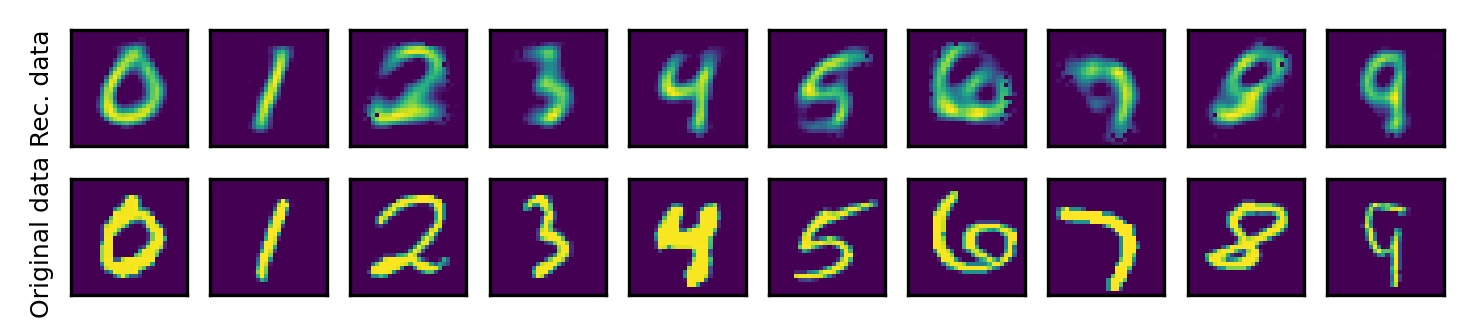

In [ ]:
plot_input_samples_after_applied_to_net( [ net.fc1.weight.data.t() , net.fc2.weight.data.t()
                                          , net.fc3.weight.data.t() , net.fc4.weight.data.t()
                                          , net.fc5.weight.data.t() , net.fc6.weight.data.t()]
                                        , []
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)

## small lr initially balanced

In [ ]:

N_iter  = 300



N_repeat = 10
N_epoch  = 10
rep_i = 0

loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(train_loader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0


for rep_i in range(N_repeat):
    print(f"\nrep_i: {rep_i}\n")

    net.reinitialize_weights(.1)

    for ii in range(N_iter):

        norm_W0 = net. norm_of_weights()
        neuron_wise_imbalancement0= net.neuron_wise_imbalancement()
        if ii%20 ==  0:
            print(neuron_wise_imbalancement0 , norm_W0)

        net.stochastic_balance()

    criterion = nn.MSELoss(reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=.00001)



    iteration = 0
    running_loss = 0.0

    for epoch in range(N_epoch):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)


            inputs = inputs.view(inputs.shape[0],-1)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            norm_W[0,rep_i,iteration] =  net.norm_of_weights()

            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()



            optimizer.step()






            running_loss += loss.item()



            if iteration % 100 == 99:
                loss_tensor[ rep_i,iteration] =  running_loss/100

                if iteration % 500 == 499:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss } neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}')


                running_loss = 0.0

            iteration +=1



print('Training Finished')

LC_BP_without_L2_regularization_small_lr_initial_balance = {

  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32) ,
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32)  ,
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)

}


if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_small_lr_initial_balance  , fp)


rep_i: 0

tensor(19345.2520) tensor(3637.8252)
tensor(82.5522) tensor(1505.8599)
tensor(20.0479) tensor(1493.9949)
tensor(10.0182) tensor(1490.0931)
tensor(3.6182) tensor(1488.4255)
tensor(0.5496) tensor(1487.5057)
tensor(0.2630) tensor(1487.3441)
tensor(0.0399) tensor(1487.2893)
tensor(0.0347) tensor(1487.2743)
tensor(0.0067) tensor(1487.2692)
tensor(0.0038) tensor(1487.2683)
tensor(0.0005) tensor(1487.2683)
tensor(0.0001) tensor(1487.2683)
tensor(2.9067e-05) tensor(1487.2681)
tensor(2.0728e-05) tensor(1487.2682)
[2,   200] loss: 755280.1264648438 neuron_wise_imbalancement_t: 0.04703591763973236
[4,   100] loss: 572779.0302734375 neuron_wise_imbalancement_t: 0.23745518922805786
[5,   300] loss: 485759.005859375 neuron_wise_imbalancement_t: 0.48944371938705444
[7,   200] loss: 446161.44970703125 neuron_wise_imbalancement_t: 0.7530643939971924
[9,   100] loss: 419396.6843261719 neuron_wise_imbalancement_t: 1.0070213079452515
[10,   300] loss: 400813.77392578125 neuron_wise_imbalancemen

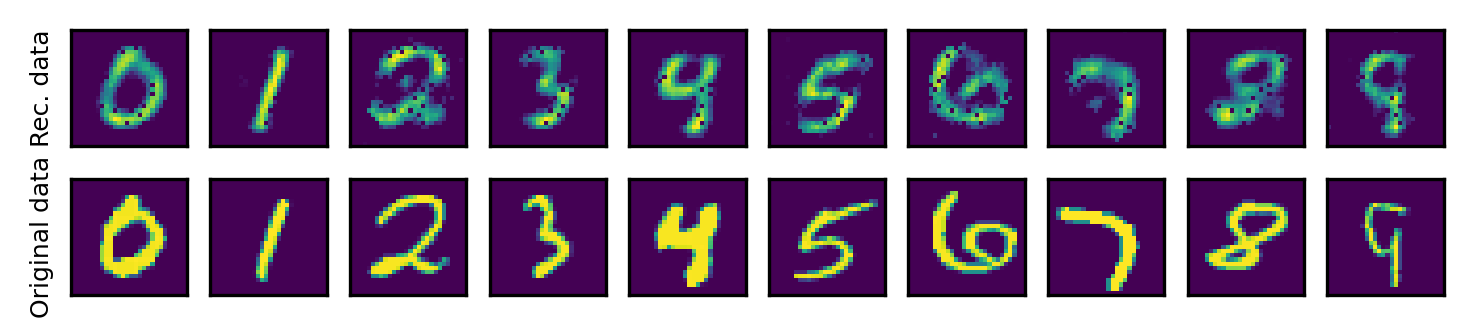

In [ ]:
plot_input_samples_after_applied_to_net( [ net.fc1.weight.data.t() , net.fc2.weight.data.t()
                                          , net.fc3.weight.data.t() , net.fc4.weight.data.t()
                                          , net.fc5.weight.data.t() , net.fc6.weight.data.t()]
                                        , []
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)

## big lr initially balanced

In [ ]:



N_iter  = 300


N_repeat = 10
N_epoch  = 10
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(train_loader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0


for rep_i in range(N_repeat):
    print(f"\nrep_i: {rep_i}\n")

    net.reinitialize_weights(.1)

    for ii in range(N_iter):

        norm_W0 = net. norm_of_weights()
        neuron_wise_imbalancement0= net.neuron_wise_imbalancement()
        if ii%20 ==  0:
            print(neuron_wise_imbalancement0 , norm_W0)

        net.stochastic_balance()

    criterion = nn.MSELoss(reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=.000044)



    iteration = 0
    running_loss = 0.0

    for epoch in range(N_epoch):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data[0].to(device), data[1].to(device)


            inputs = inputs.view(inputs.shape[0],-1)
            optimizer.zero_grad()


            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            norm_W[0,rep_i,iteration] =  net.norm_of_weights()

            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = neuron_wise_imbalancement_t




            optimizer.step()






            running_loss += loss.item()



            if iteration % 100 == 99:
                loss_tensor[ rep_i,iteration] =  running_loss/100

                if iteration % 500 == 499:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss } neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}')


                running_loss = 0.0

            iteration +=1



print('Training Finished')

LC_BP_without_L2_regularization_big_lr_initial_balance = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32) ,
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32)  ,
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)


}



if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_without_L2_regularization_big_lr_initial_balance  , fp)


rep_i: 0

tensor(19111.5508) tensor(3636.4763)
tensor(199.6220) tensor(1521.8435)
tensor(3.9440) tensor(1506.7031)
tensor(0.2458) tensor(1506.2050)
tensor(0.0574) tensor(1506.1681)
tensor(0.0110) tensor(1506.1602)
tensor(0.0057) tensor(1506.1573)
tensor(0.0026) tensor(1506.1564)
tensor(0.0011) tensor(1506.1560)
tensor(0.0015) tensor(1506.1558)
tensor(0.0002) tensor(1506.1555)
tensor(5.7005e-05) tensor(1506.1556)
tensor(1.8314e-05) tensor(1506.1553)
tensor(8.6618e-06) tensor(1506.1550)
tensor(4.4975e-06) tensor(1506.1550)
[2,   200] loss: 632750.0825195312 neuron_wise_imbalancement_t: 3.891777515411377
[4,   100] loss: 491410.45361328125 neuron_wise_imbalancement_t: 6.661316394805908
[5,   300] loss: 438138.9416503906 neuron_wise_imbalancement_t: 9.384952545166016
[7,   200] loss: 388778.0322265625 neuron_wise_imbalancement_t: 11.986129760742188
[9,   100] loss: 364561.06787109375 neuron_wise_imbalancement_t: 14.596981048583984
[10,   300] loss: 346612.2578125 neuron_wise_imbalancement

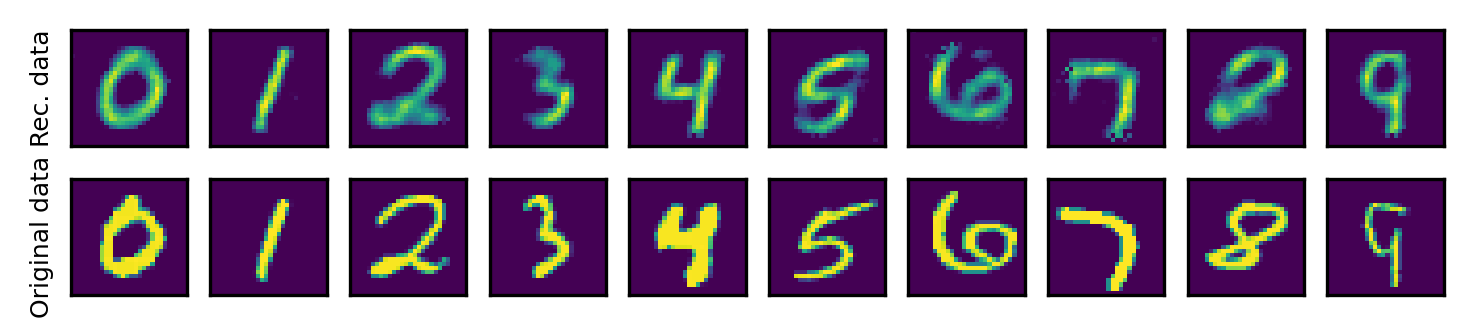

In [ ]:
plot_input_samples_after_applied_to_net( [ net.fc1.weight.data.t() , net.fc2.weight.data.t()
                                          , net.fc3.weight.data.t() , net.fc4.weight.data.t()
                                          , net.fc5.weight.data.t() , net.fc6.weight.data.t()]
                                        , []
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)

## big lr initially balanced with L2 regularizer

In [ ]:








N_repeat = 10
N_epoch  = 10
rep_i = 0
loss_tensor =  torch.zeros( [  N_repeat ,  N_epoch*len(train_loader) ]  )


neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );
norm_W = torch.zeros( [ 1 , N_repeat , N_epoch*len(train_loader)]  );

neuron_wise_imbalancement [:] =  float('nan')
loss_tensor [:] =  float('nan')

iteration = 0


for rep_i in range(N_repeat):
    print(f"\nrep_i: {rep_i}\n")

    net.reinitialize_weights(.1)

    for ii in range(N_iter):

        norm_W0 = net. norm_of_weights()
        neuron_wise_imbalancement0= net.neuron_wise_imbalancement()
        if ii%20 ==  0:
            print(neuron_wise_imbalancement0 , norm_W0)

        net.stochastic_balance()



    criterion = nn.MSELoss(reduction='sum')

    optimizer = optim.SGD(net.parameters(), lr=0.000044)


    iteration = 0
    running_loss = 0.0

    for epoch in range(N_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)


            inputs = inputs.view(inputs.shape[0],-1)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()

            norm_W[0,rep_i,iteration] =  net.norm_of_weights()

            neuron_wise_imbalancement_t = net.neuron_wise_imbalancement()



            neuron_wise_imbalancement[0,rep_i,iteration] = net.neuron_wise_imbalancement()




            optimizer.step()





            net.weight_decay(0.0009)

            # print statistics
            running_loss += loss.item()


            if iteration % 100 == 99:
                loss_tensor[ rep_i,iteration] =  running_loss/100

                if iteration % 500 == 499:

                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss } neuron_wise_imbalancement_t: {neuron_wise_imbalancement_t}')


                running_loss = 0.0

            iteration +=1



print('Training Finished')

LC_BP_with_L2_regularization_big_lr_initial_balance = {


  "neuron_wise_imbalancement" : neuron_wise_imbalancement.detach().clone().cpu().to(torch.float32) ,
  "norm_W" : norm_W.detach().clone().cpu().to(torch.float32)  ,
  "loss_tensor" : loss_tensor.detach().clone().cpu().to(torch.float32)
}



if mount_drive==True:

  str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( LC_BP_with_L2_regularization_big_lr_initial_balance  , fp)


rep_i: 0

tensor(18858.1504) tensor(3611.0818)
tensor(168.1577) tensor(1528.5376)
tensor(7.9469) tensor(1493.0471)
tensor(1.3011) tensor(1490.7853)
tensor(0.6218) tensor(1490.2355)
tensor(0.2036) tensor(1490.0240)
tensor(0.0755) tensor(1489.9702)
tensor(0.0386) tensor(1489.9519)
tensor(0.0091) tensor(1489.9415)
tensor(0.0018) tensor(1489.9392)
tensor(0.0007) tensor(1489.9386)
tensor(0.0013) tensor(1489.9385)
tensor(0.0002) tensor(1489.9380)
tensor(6.8663e-05) tensor(1489.9381)
tensor(2.2235e-05) tensor(1489.9382)
[2,   200] loss: 722901.9521484375 neuron_wise_imbalancement_t: 0.9763160943984985
[4,   100] loss: 558935.16015625 neuron_wise_imbalancement_t: 0.4240189790725708
[5,   300] loss: 504577.48583984375 neuron_wise_imbalancement_t: 0.22068190574645996
[7,   200] loss: 481469.15966796875 neuron_wise_imbalancement_t: 0.15901513397693634
[9,   100] loss: 464393.73876953125 neuron_wise_imbalancement_t: 0.15526223182678223
[10,   300] loss: 450753.8093261719 neuron_wise_imbalancement

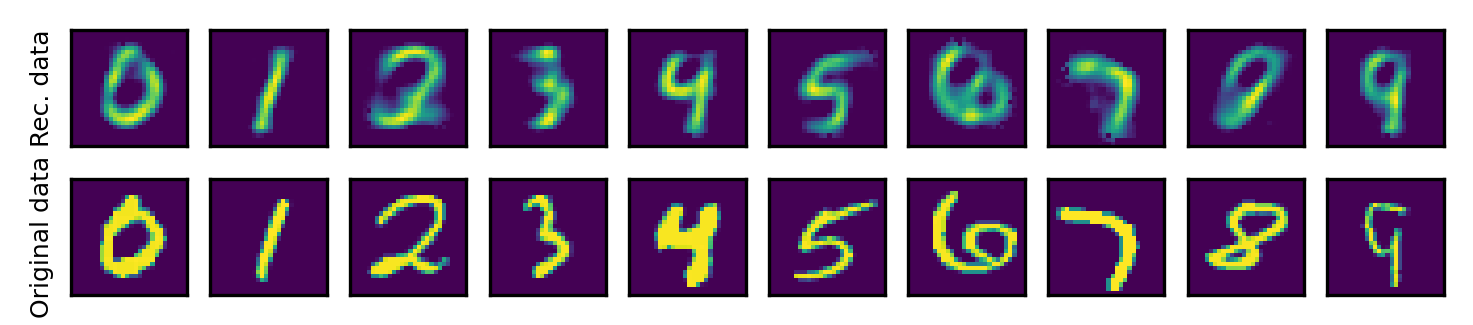

In [ ]:
plot_input_samples_after_applied_to_net( [ net.fc1.weight.data.t() , net.fc2.weight.data.t()
                                          , net.fc3.weight.data.t() , net.fc4.weight.data.t()
                                          , net.fc5.weight.data.t() , net.fc6.weight.data.t()]
                                        , []
                                        , ten_samples,(width_height_input_image,width_height_input_image)
                                        , activation_function ,bias = None)

## Plot Neuron-wise imbalancement with regularazer vs without regularizer

torch.Size([10, 3000])
torch.Size([10, 3000])


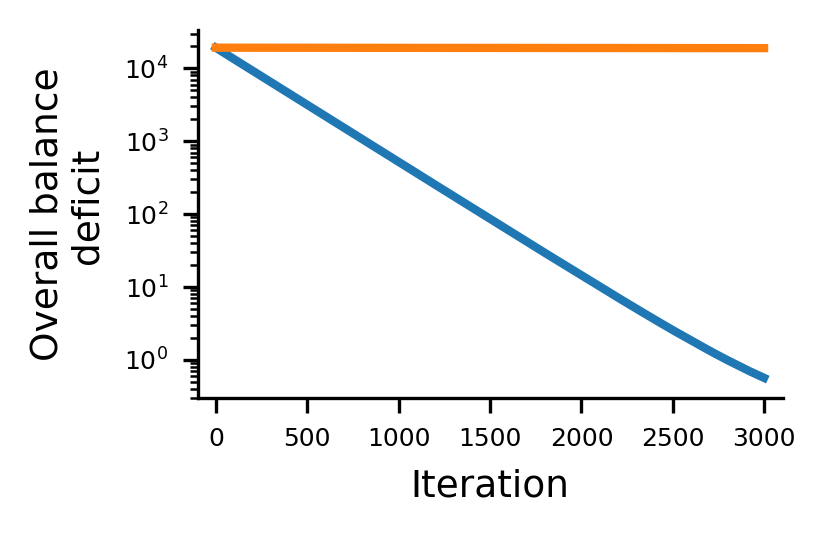

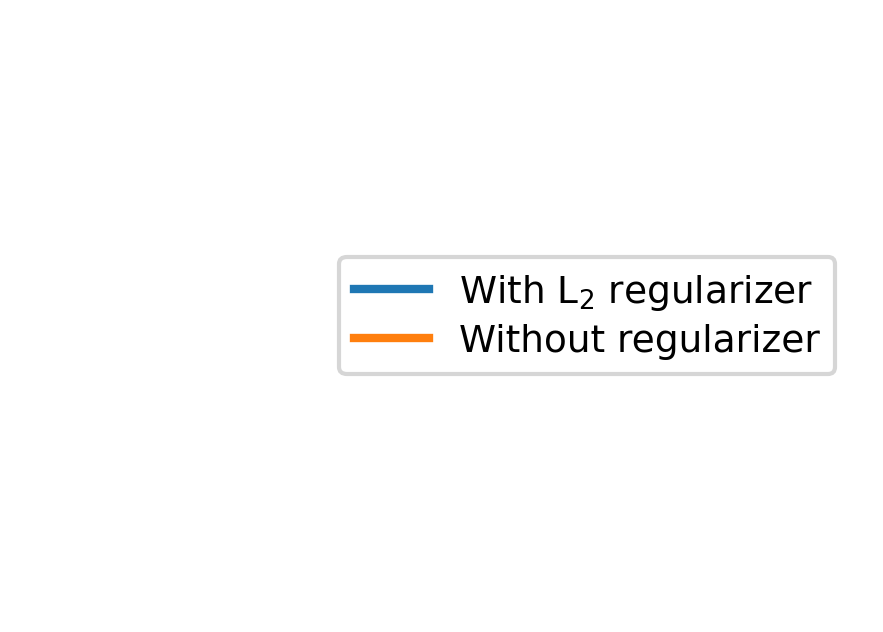

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:
  LC_BP_without_L2_regularization_big_lr = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:
  LC_BP_with_L2_regularization_big_lr = CPU_Unpickler(fp).load()



max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')









#############################################################################################################################

x = LC_BP_with_L2_regularization_big_lr["neuron_wise_imbalancement"][0,:,0:].to(torch.float32)
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6



x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )





#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr["neuron_wise_imbalancement"][0,:,0:].to(torch.float32)
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6


x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )




plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')
















plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Overall balance\n deficit", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)



ax.ticklabel_format(style='sci',scilimits=(0,0), axis='y' )
ax.yaxis.get_offset_text().set_fontsize(plt_fontsize_label_)

plt.xlim(-100,3100)

ax.get_yaxis().get_offset_text().set_position((-0.05,0))


ax.set_yscale('log')



if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_wise_imbalancement_with_vs_without_regularizer.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With $L_2$ regularizer'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer'
, linewidth=1.3  , markersize = markersize_ , color = color_cycle[1])








ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_neuron_wise_imbalancement_with_vs_without_regularizer.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## Plot LOSS with regularazer vs without regularizer

torch.Size([10, 3000])
torch.float32
30
torch.Size([10, 3000])
torch.float32


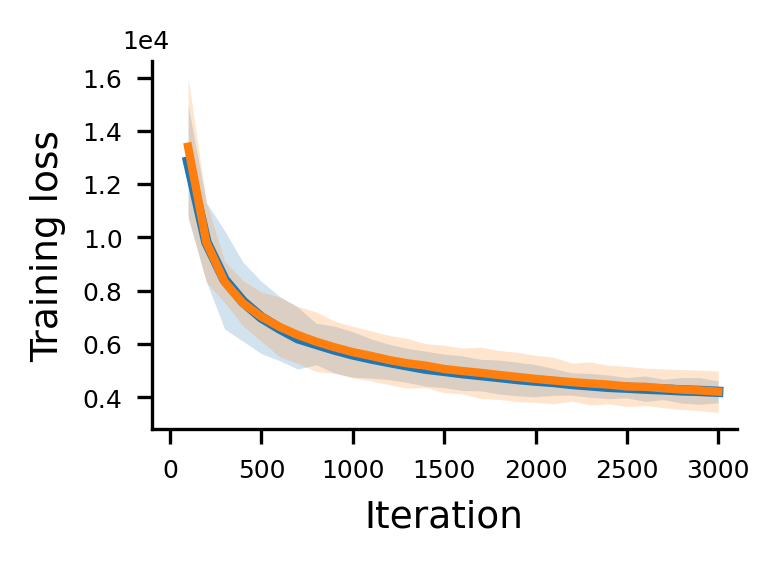

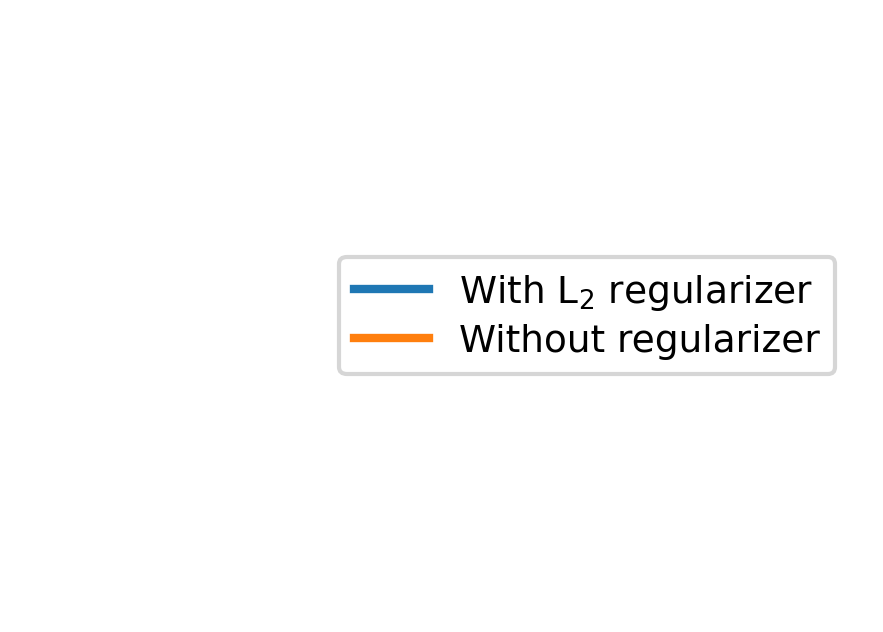

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr = CPU_Unpickler(fp).load()



max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')









#############################################################################################################################

x = LC_BP_with_L2_regularization_big_lr["loss_tensor"][:,0:]
print(LC_BP_with_L2_regularization_big_lr["loss_tensor"].shape)
print(LC_BP_with_L2_regularization_big_lr["loss_tensor"].dtype)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth=2.5  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )



print(len(x_list))


#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr["loss_tensor"][:,0:]
print(LC_BP_with_L2_regularization_big_lr["loss_tensor"].shape)
print(LC_BP_with_L2_regularization_big_lr["loss_tensor"].dtype)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )









plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Training loss", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


plt.xlim(-100,3100)



ax.ticklabel_format(style='sci',scilimits=(0,0), axis='y' )
ax.yaxis.get_offset_text().set_fontsize(plt_fontsize_label_)

ax.get_yaxis().get_offset_text().set_position((-0.05,0))

if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_loss_with_vs_without_regularizer.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With $L_2$ regularizer'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer'
, linewidth=1.3  , markersize = markersize_ , color = color_cycle[1])








ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_loss_with_vs_without_regularizer.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## Plot norm of weights with regularazer vs without regularizer

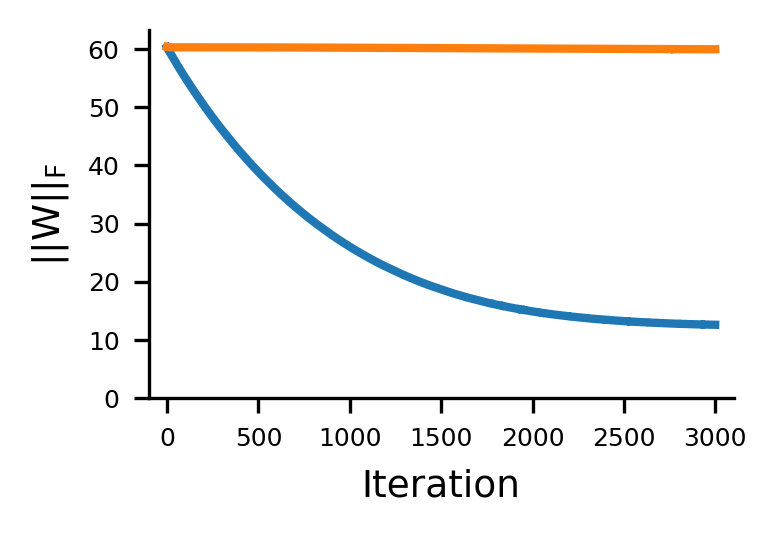

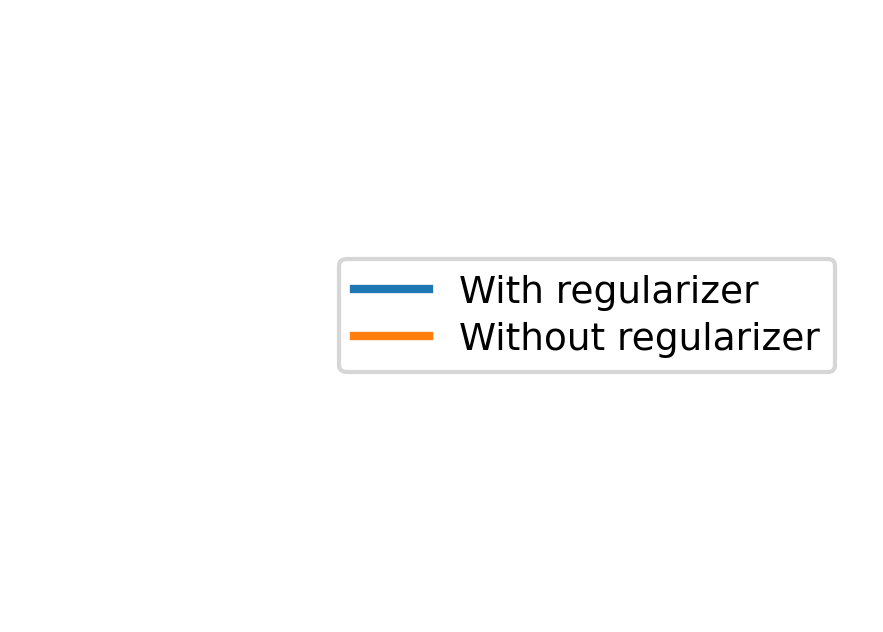

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = LC_BP_with_L2_regularization_big_lr["norm_W"][0,:,0:].to(torch.float32).sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)*6
plt.fill_between( range(1,x_std.shape[0]+1)  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )



x = LC_BP_without_L2_regularization_big_lr["norm_W"][0,:,0:].to(torch.float32).sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0)*6
plt.fill_between( range(1,x_std.shape[0]+1)  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )



plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W||_F$", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


axes = plt.gca()
plt.ylim(0,axes.get_ylim()[1])
plt.xlim(-100,3100)



if mount_drive:
    plt.savefig( base_directory_figure_str + '/norms_of_weights_with_vs_without_regularizer.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With regularizer'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer'
, linewidth=1.3  , markersize = markersize_ , color = color_cycle[1])








ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)

leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_norms_of_weights_with_vs_without_regularizer.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## Plot Neuron-wise imbalancement with initial balance

torch.Size([10, 3000])
torch.Size([10, 3000])
torch.Size([10, 3000])


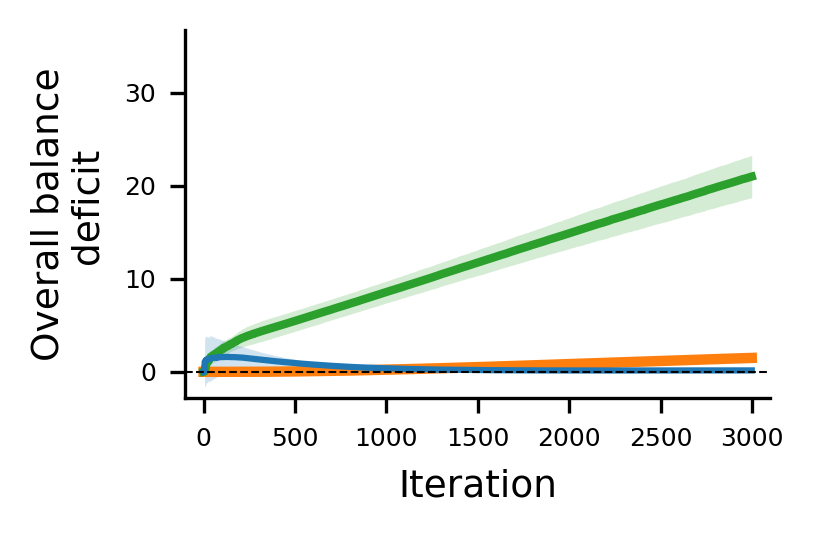

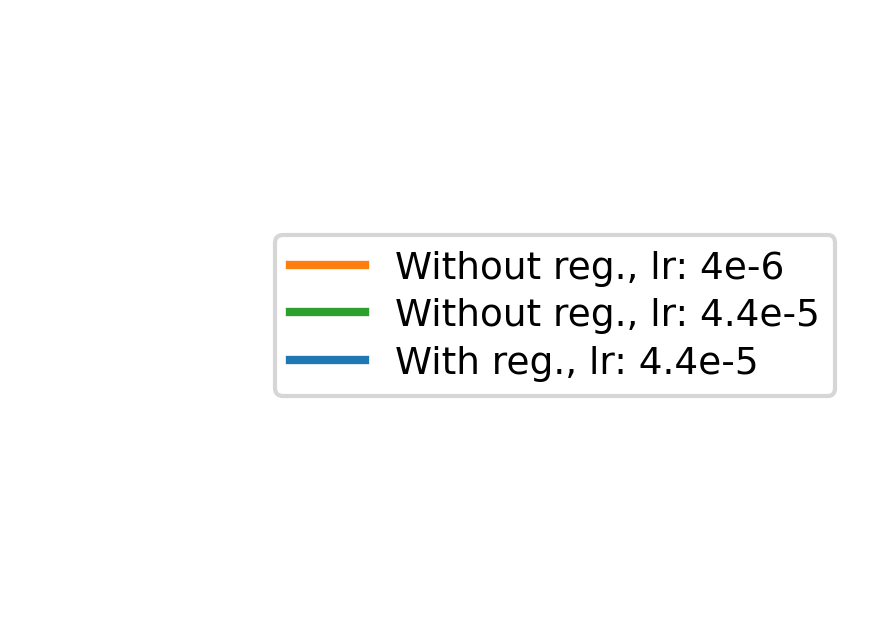

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_small_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()




max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')





#############################################################################################################################

x = LC_BP_without_L2_regularization_small_lr_initial_balance["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth= 2.5 , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )





#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr_initial_balance["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)


x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[2] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[2] )



#############################################################################################################################


x = LC_BP_with_L2_regularization_big_lr_initial_balance["neuron_wise_imbalancement"][0,:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=1.5  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )





plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')












plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Overall balance\n deficit", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)

axes = plt.gca()
plt.ylim(axes.get_ylim()[0],axes.get_ylim()[1]*1.5)

plt.xlim(-100,3100)
ax.get_yaxis().get_offset_text().set_position((-0.05,0))


if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_wise_imbalancement_with_initial_balance.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without reg., lr: 4e-6'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[1])

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without reg., lr: 4.4e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[2])




plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With reg., lr: 4.4e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])




ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)

leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_neuron_wise_imbalancement_with_initial_balance.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## Plot LOSS with regularazer with initial balance

torch.Size([10, 3000])
torch.Size([10, 3000])
torch.Size([10, 3000])


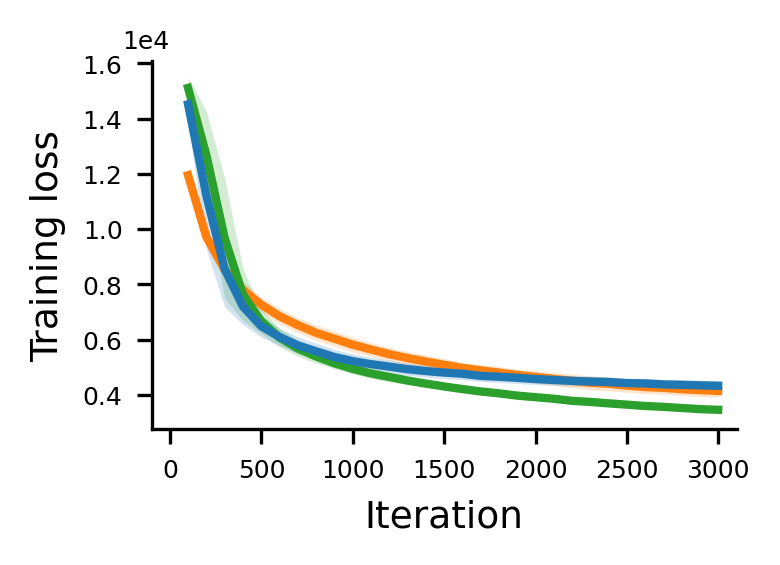

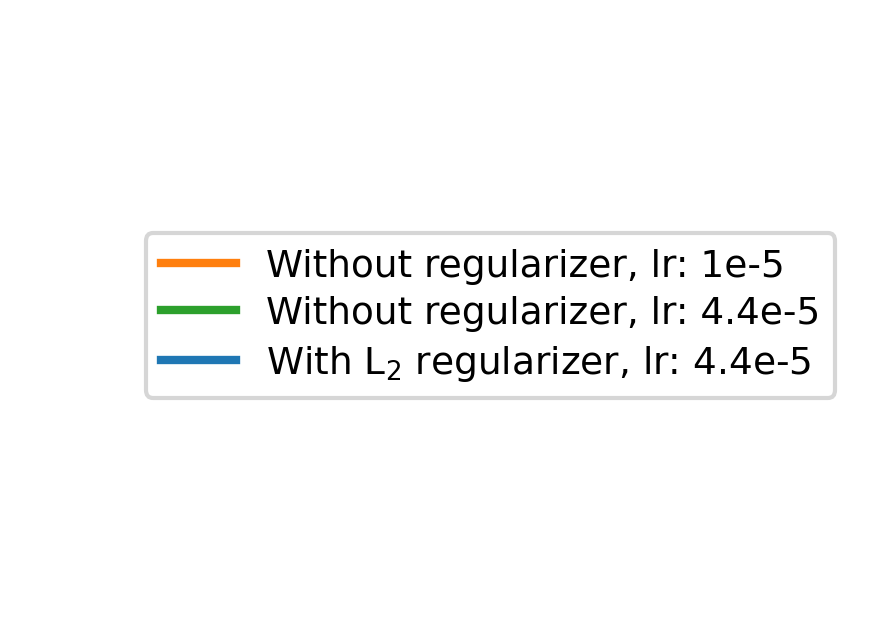

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_small_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')






#############################################################################################################################

x = LC_BP_without_L2_regularization_small_lr_initial_balance["loss_tensor"][:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'With regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )





#############################################################################################################################


x = LC_BP_without_L2_regularization_big_lr_initial_balance["loss_tensor"][:,0:]
print(x.shape)
x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[2] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[2] )

#############################################################################################################################


x = LC_BP_with_L2_regularization_big_lr_initial_balance["loss_tensor"][:,0:]
print(x.shape)

x_mean = x.mean(dim=0) .squeeze()

x_list = []
y_list = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list.append(x_mean[i])


plt.plot( x_list , y_list  ,  linestyle_1  , dash_capstyle='round'  , label = r'Without regularizer'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0) .squeeze()*6

x_list = []
y_list1 = []
y_list2 = []

for i in range(x_mean.shape[0]):
  if torch.isnan(x_mean[i])==False:
    x_list.append(i)
    y_list1.append(x_mean[i] - x_std[i] )
    y_list2.append(x_mean[i] + x_std[i] )


plt.fill_between( x_list  , y_list1, y_list2  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )










plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Training loss", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)

plt.xlim(-100,3100)




ax.ticklabel_format(style='sci',scilimits=(0,0), axis='y' )
ax.yaxis.get_offset_text().set_fontsize(plt_fontsize_label_)


ax.get_yaxis().get_offset_text().set_position((-0.05,0))





if mount_drive:
    plt.savefig( base_directory_figure_str + '/neuron_loss_with_initial_balance.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')



plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, lr: 1e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[1])

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, lr: 4.4e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[2])




plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With $L_2$ regularizer, lr: 4.4e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])




ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_loss_with_vs_initial_balance.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







## Plot norm of weights with with initial balance

torch.Size([10, 3000])
torch.Size([10, 3000])
torch.Size([10, 3000])


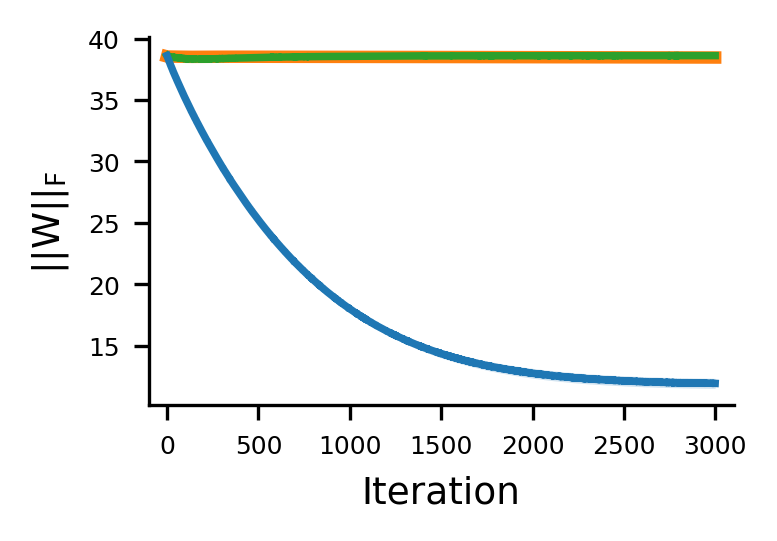

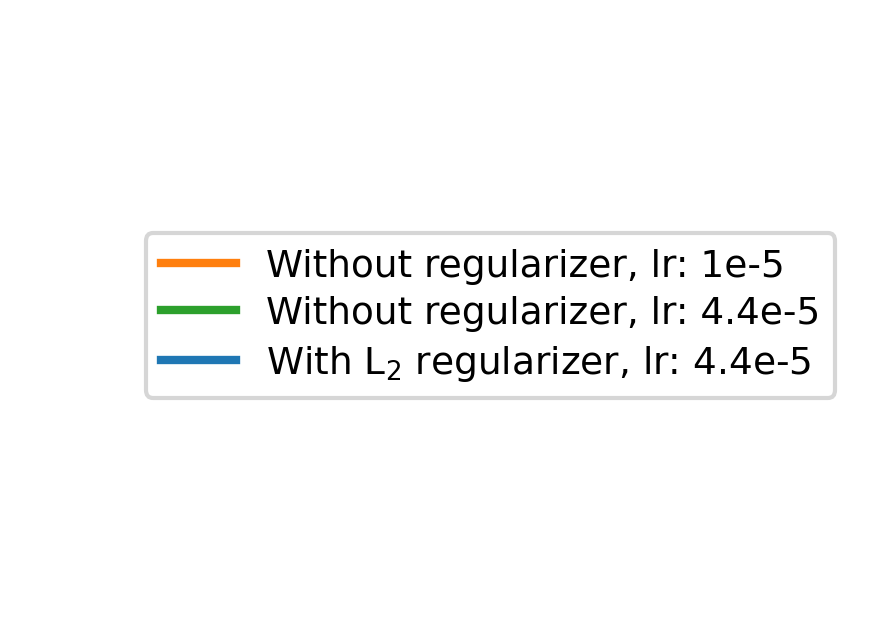

In [ ]:
str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_small_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_small_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_without_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_without_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()



str_direction = base_directory_data_str + "LC_BP_with_L2_regularization_big_lr_initial_balance" + ".txt"


with open( str_direction , "rb") as fp:   #Pickling
  LC_BP_with_L2_regularization_big_lr_initial_balance = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.45 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = LC_BP_without_L2_regularization_small_lr_initial_balance["norm_W"][0,:,0:].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=3  , markersize = markersize_ , color = color_cycle[1] )
x_std = x.std(dim=0)*6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[1] )



x = LC_BP_without_L2_regularization_big_lr_initial_balance["norm_W"][0,:,0:].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=1.8  , markersize = markersize_ , color = color_cycle[2] )
x_std = x.std(dim=0)*6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[2] )

x = LC_BP_with_L2_regularization_big_lr_initial_balance["norm_W"][0,:,0:].sqrt()
print(x.shape)

x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=1.8  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)*6
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )

plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W||_F$", fontsize= plt_fontsize_text_)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)



plt.xlim(-100,3100)




axes = plt.gca()

if mount_drive:
    plt.savefig( base_directory_figure_str + '/norms_of_weights_with_initial_balance.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()








###################################################################################
linewidth_1 = 1
linestyle_1 = linestyle_1_

figsize_ = (figure_width1 , figure_width1*0.7 )


plt.figure(num = None, figsize=figsize_ , dpi=300, facecolor='w', edgecolor='k')






plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, lr: 1e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[1])

plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'Without regularizer, lr: 4.4e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[2])




plt.plot( []  ,  linestyle_1  , dash_capstyle='round'
 , label = r'With $L_2$ regularizer, lr: 4.4e-5'
, linewidth=0.8  , markersize = markersize_  , color = color_cycle[0])



ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_color('none')

ax.set_frame_on(False)


leg = plt.legend( loc= 'center right' ,  fontsize = plt_fontsize_text_ , labelspacing = 0.3 , columnspacing = 0.7 , ncol=1 )
plt.yticks([])
plt.xticks([])
for line in leg.get_lines():
    line.set_linewidth(2.0)



plt.axis('off')



if mount_drive:
    str_dir = base_directory_figure_str + "/legend_norms_of_weights_with_initial_balance.jpg"

    export_legend( leg  , filename = str_dir  )


plt.show()







# 3) various balancing algorithms converge to a unique balanced state

In [ ]:
net1 = Net()
net1.to(device)



Net(
  (fc1): Linear(in_features=784, out_features=200, bias=False)
  (fc2): Linear(in_features=200, out_features=100, bias=False)
  (fc3): Linear(in_features=100, out_features=50, bias=False)
  (fc4): Linear(in_features=50, out_features=100, bias=False)
  (fc5): Linear(in_features=100, out_features=200, bias=False)
  (fc6): Linear(in_features=200, out_features=784, bias=False)
)

In [ ]:
net1.reinitialize_weights(.1)

net1.save_weights()

In [ ]:
net1.load_weights()

N_repeat = 1
N_iter  = 150
norm_W = torch.zeros( [ 1 , N_repeat , N_iter ]  )
neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_iter +1 ] );


for i in range(N_iter):
  # print(i)

  norm_W [0,0,i] = net1. norm_of_weights()
  neuron_wise_imbalancement[0,0,i] = net1.neuron_wise_imbalancement()
  if i%20 ==  0:
    print(neuron_wise_imbalancement[0,0,i] , norm_W [0,0,i])

  net1.stochastic_balance()

i+=1
neuron_wise_imbalancement[0,0,i] = net1.neuron_wise_imbalancement()

print(neuron_wise_imbalancement[0,0,i])

stochastic_balancing_first_time = {
    "norm_W" : norm_W,
  "neuron_wise_imbalancement" : neuron_wise_imbalancement

}



W_balanced_fc1 = net1.fc1.weight.data.clone()
W_balanced_fc2 = net1.fc2.weight.data.clone()
W_balanced_fc3 = net1.fc3.weight.data.clone()
W_balanced_fc4 = net1.fc4.weight.data.clone()
W_balanced_fc5 = net1.fc5.weight.data.clone()
W_balanced_fc6 = net1.fc6.weight.data.clone()


tensor(19237.0195) tensor(3638.9153)
tensor(495.1845) tensor(1609.3589)
tensor(4.9690) tensor(1500.3639)
tensor(1.3461) tensor(1498.2269)
tensor(0.5711) tensor(1497.8750)
tensor(0.1518) tensor(1497.7491)
tensor(0.1544) tensor(1497.7172)
tensor(0.0537) tensor(1497.6942)
tensor(0.0226)


In [ ]:

N_repeat = 100
N_iter  = 150
norm_W = torch.zeros( [ 1 , N_repeat , N_iter ]  )
neuron_wise_imbalancement = torch.zeros( [ 1 , N_repeat , N_iter +1 ] );

distnce_to_first_balanced = torch.zeros( [ 1 , N_repeat , N_iter +1 ] );

for rep_i in range(N_repeat):
    net1.load_weights()

    for i in range(N_iter):
        # print(i)
        sum=0

        sum+= (W_balanced_fc1 - net1.fc1.weight.data).norm()**2
        sum+= (W_balanced_fc2 - net1.fc2.weight.data).norm()**2
        sum+= (W_balanced_fc3 - net1.fc3.weight.data).norm()**2
        sum+= (W_balanced_fc4 - net1.fc4.weight.data).norm()**2
        sum+= (W_balanced_fc5 - net1.fc5.weight.data).norm()**2
        sum+= (W_balanced_fc6 - net1.fc6.weight.data).norm()**2


        distnce_to_first_balanced[0,rep_i,i] = sum

        norm_W [0,rep_i,i] = net1. norm_of_weights()
        neuron_wise_imbalancement[0,rep_i,i] = net1.neuron_wise_imbalancement()
        # if i%20 ==  0:
        #     print(neuron_wise_imbalancement[0,rep_i,i] , norm_W [0,rep_i,i] , distnce_to_first_balanced[0,rep_i,i])

        net1.stochastic_balance()

    print(neuron_wise_imbalancement[0,rep_i,i] , distnce_to_first_balanced[0,rep_i,i])

    i+=1
    neuron_wise_imbalancement[0,rep_i,i] = net1.neuron_wise_imbalancement()

print(neuron_wise_imbalancement[0,0,i])

stochastic_balancing = {
     "norm_W" : norm_W,
    "distnce_to_first_balanced" : distnce_to_first_balanced,
  "neuron_wise_imbalancement" : neuron_wise_imbalancement

}

tensor(0.0978) tensor(0.0052)
tensor(0.0059) tensor(0.0117)
tensor(0.0063) tensor(0.0114)
tensor(0.0257) tensor(0.0007)
tensor(0.0300) tensor(0.0015)
tensor(0.0351) tensor(0.0214)
tensor(0.0002) tensor(0.0050)
tensor(0.1162) tensor(0.0261)
tensor(0.4658) tensor(0.0882)
tensor(0.0004) tensor(0.0072)
tensor(0.0007) tensor(0.0073)
tensor(0.0198) tensor(0.0008)
tensor(0.0146) tensor(0.0163)
tensor(0.1261) tensor(0.0045)
tensor(9.3026e-05) tensor(0.0053)
tensor(0.0364) tensor(0.0264)
tensor(0.0112) tensor(0.0015)
tensor(0.0624) tensor(0.0291)
tensor(0.0079) tensor(0.0021)
tensor(0.0613) tensor(0.0032)
tensor(0.0013) tensor(0.0040)
tensor(0.0006) tensor(0.0070)
tensor(0.0033) tensor(0.0037)
tensor(0.0215) tensor(0.0201)
tensor(0.1030) tensor(0.0279)
tensor(0.0159) tensor(0.0012)
tensor(6.6957e-05) tensor(0.0063)
tensor(0.0014) tensor(0.0039)
tensor(0.0700) tensor(0.0040)
tensor(3.1021e-06) tensor(0.0059)
tensor(0.0277) tensor(0.0012)
tensor(0.0211) tensor(0.0002)
tensor(2.4465e-05) tensor(0.

In [ ]:

if mount_drive==True:

  str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"

  with open( str_direction  , "wb") as fp:   #Pickling
    pickle.dump( stochastic_balancing  , fp)

## Plot

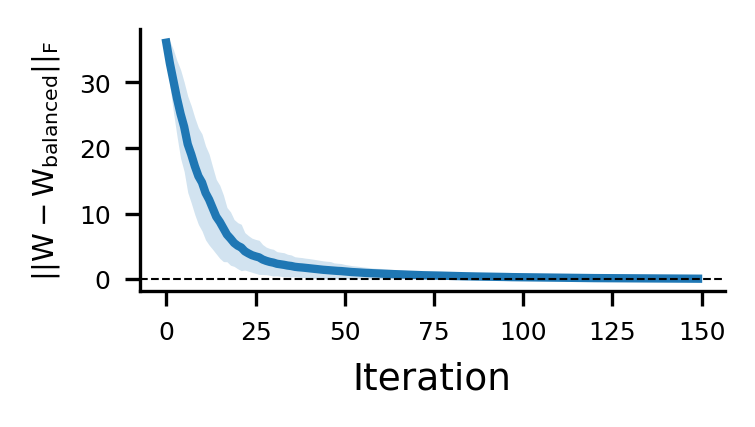

In [ ]:
if mount_drive==True:

    str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"


    with open( str_direction , "rb") as fp:   #Pickling
        stochastic_balancing = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.32 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = stochastic_balancing["distnce_to_first_balanced"][0,:,0:-1].sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )






plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W-W_{balanced}||_F$", fontsize= plt_fontsize_text_ -2)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)


plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')




if mount_drive:
    plt.savefig( base_directory_figure_str + '/stochastic_balancing.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()






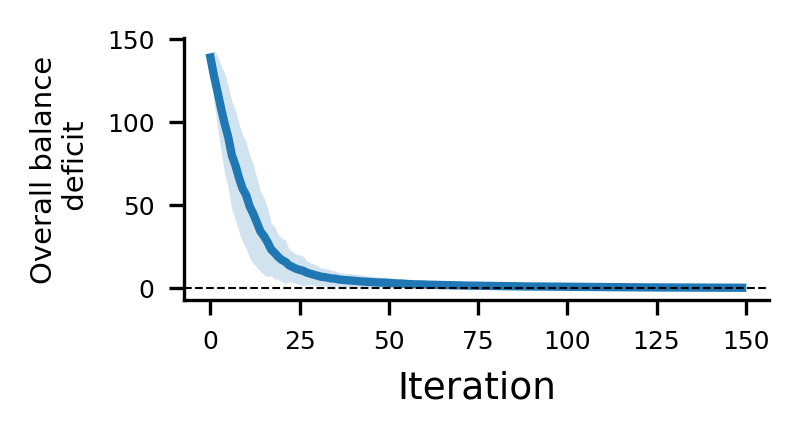

In [ ]:
if mount_drive==True:

    str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"


    with open( str_direction , "rb") as fp:   #Pickling
        stochastic_balancing = CPU_Unpickler(fp).load()


max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.32 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = stochastic_balancing["neuron_wise_imbalancement"][0,:,0:-1].sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )






plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel("Overall balance\n deficit", fontsize= plt_fontsize_text_-2)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)



plt.axhline(y=0 , linewidth=0.5 , color='k', linestyle='--')



if mount_drive:
    plt.savefig( base_directory_figure_str + '/stochastic_balancing_neuron_wise_imbalancement.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()







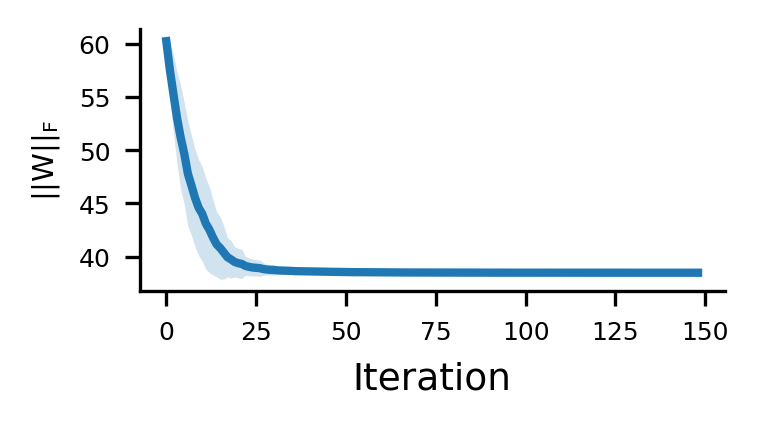

In [ ]:
if mount_drive==True:
    str_direction = base_directory_data_str + "stochastic_balancing" + ".txt"


    with open( str_direction , "rb") as fp:   #Pickling
        stochastic_balancing = CPU_Unpickler(fp).load()



max_iteration = -1
###################################################################################
linewidth_1 = 1
linestyle_1_='-'
linestyle_1 = linestyle_1_
markersize_ =1

figsize_ = (figure_width1*0.71 , figure_width1*0.32 )
plt.figure(num = None, figsize=figsize_, dpi=300, facecolor='w', edgecolor='k')

x = stochastic_balancing["norm_W"][0,:,0:max_iteration].sqrt()
x_mean = x.mean(dim=0)
plt.plot( x_mean  ,  linestyle_1  , dash_capstyle='round' , label = r'$\ell=0$'
, linewidth=2  , markersize = markersize_ , color = color_cycle[0] )
x_std = x.std(dim=0)
plt.fill_between( range(x_std.shape[0])  , x_mean-x_std , x_mean+x_std  , alpha=0.2
                 , linewidth=0 , color = color_cycle[0] )






plt.xlabel("Iteration", fontsize= plt_fontsize_text_)
plt.ylabel(r"$||W||_F$", fontsize= plt_fontsize_text_-2)


ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=plt_fontsize_label_)
ax.tick_params(axis='y', labelsize=plt_fontsize_label_)




if mount_drive:
    plt.savefig( base_directory_figure_str + '/stochastic_balancing_L_2norm_.jpg'
              , dpi=300 , bbox_inches='tight' ,  pad_inches= 0.001  )

plt.show()

